In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def calculate_image_brightness(image):
    """Calculate average brightness of an image"""
    try:
        # Convert to grayscale if the image is in color
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        # Calculate average brightness
        return np.mean(gray)
    except Exception as e:
        print(f"Error calculating image brightness: {e}")
        return 0

In [3]:
from picamera2 import Picamera2
import libcamera
picam2 = Picamera2()
frame_size = (4608, 2592)

# Get initial exposure time based on time of day

config = picam2.create_still_configuration(
    {"size": frame_size},
    controls={"ExposureTime": 50000},
    transform=libcamera.Transform(vflip=1),
)
picam2.configure(config)
picam2.start()


[0:01:38.169122156] [2503]  INFO Camera camera_manager.cpp:326 libcamera v0.5.0+59-d83ff0a4
[0:01:38.179310747] [2526]  INFO RPI pisp.cpp:720 libpisp version v1.2.1 981977ff21f3 29-04-2025 (14:13:50)
[0:01:38.180844050] [2526]  WARN CameraSensorProperties camera_sensor_properties.cpp:473 No static properties available for 'imx708_wide'
[0:01:38.180864345] [2526]  WARN CameraSensorProperties camera_sensor_properties.cpp:475 Please consider updating the camera sensor properties database
[0:01:38.192660401] [2526]  WARN CameraSensor camera_sensor_legacy.cpp:501 'imx708_wide': No sensor delays found in static properties. Assuming unverified defaults.
[0:01:38.193385471] [2526]  INFO RPI pisp.cpp:1179 Registered camera /base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a to CFE device /dev/media1 and ISP device /dev/media2 using PiSP variant BCM2712_C0
[0:01:38.201294099] [2503]  INFO Camera camera.cpp:1205 configuring streams: (0) 4608x2592-BGR888 (1) 4608x2592-GRBG_PISP_COMP1
[0:01:38.201551

In [4]:
def calculate_image_quality(image):
    """Calculate image quality metrics including brightness, contrast, and histogram distribution"""
    try:
        # Convert to grayscale if the image is in color
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        # Calculate average brightness
        avg_brightness = np.mean(gray)
        
        # Calculate standard deviation (simple contrast measure)
        std_dev = np.std(gray)
        
        # Calculate histogram
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist = hist.flatten() / hist.sum()  # Normalize histogram
        
        # Calculate histogram standard deviation (measure of spread)
        hist_indices = np.arange(256)
        hist_mean = np.sum(hist_indices * hist)
        hist_std = np.sqrt(np.sum(((hist_indices - hist_mean) ** 2) * hist))
        
        # Calculate contrast ratio (simplified)
        p_low = np.percentile(gray, 5)  # 5th percentile
        p_high = np.percentile(gray, 95)  # 95th percentile
        if p_low > 0:  # Avoid division by zero
            contrast_ratio = p_high / p_low
        else:
            contrast_ratio = p_high
        
        return {
            'avg_brightness': avg_brightness,
            'std_dev': std_dev,
            'hist_std': hist_std,
            'contrast_ratio': contrast_ratio
        }
    except Exception as e:
        print(f"Error calculating image quality: {e}")
        return {
            'avg_brightness': 0,
            'std_dev': 0,
            'hist_std': 0,
            'contrast_ratio': 0
        }

24975
24975
24975
44982
44982
44982
64989
64989
64989
84996
84996
84996
104977
104977
104977
124984
124984
124984
144991
144991
144991
164998
164998
164998
184978
184978
184978
204985


(-0.5, 4607.5, 2591.5, -0.5)

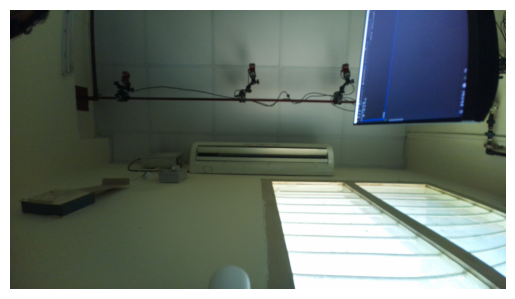

In [ ]:
desired_brightness = 120  # Set desired brightness level (0-1)
exposure_tolerance = 50  # Set tolerance for brightness adjustment
brightness_tolerance = 20
exposure_time = 5000

picam2.set_controls({'ExposureTime': exposure_time})

def set_exposure_time(exposure_time):
    """Set the exposure time for the camera"""
    desired_exposure_time = exposure_time  # Set desired exposure time in microseconds
    exposure_tolerance = 50  # Set tolerance for exposure adjustment
    
    picam2.set_controls({'ExposureTime': exposure_time})

    for i in range(5):
        picam2.capture_array() # flush image
        actual_exposure = picam2.capture_metadata()['ExposureTime']
        print(actual_exposure)
        if abs(actual_exposure - desired_exposure_time) <= exposure_tolerance:
            break
desired_exposure_time = exposure_time

while True:
    frame = picam2.capture_array()
    brightness = calculate_image_quality(frame)['avg_brightness']

    if abs(brightness - desired_brightness) <= brightness_tolerance:
        break
    # Adjust exposure time based on brightness
    if brightness < desired_brightness:
        desired_exposure_time = desired_exposure_time + 20000
        set_exposure_time(desired_exposure_time)
    else:
        desired_exposure_time = desired_exposure_time + 20000
        set_exposure_time(desired_exposure_time)



plt.imshow(frame)
plt.axis('off')



In [22]:
def analyze_image_histogram(image):
    """Analyze image histogram to check for proper exposure distribution"""
    try:
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Calculate histogram
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist = hist.flatten()
        
        # Check for overexposure (too many bright pixels)
        bright_pixels = np.sum(hist[220:]) / np.sum(hist)
        
        # Check for underexposure (too many dark pixels)
        dark_pixels = np.sum(hist[:30]) / np.sum(hist)
        
        # Calculate the percentage of pixels in the ideal middle range
        # midrange_pixels = np.sum(hist[self.target_contrast_range[0]:self.target_contrast_range[1]]) / np.sum(hist)
        
        return {
            'overexposed': bright_pixels > 0.15,  # More than 15% very bright pixels
            'underexposed': dark_pixels > 0.15,   # More than 15% very dark pixels
            # 'midrange_percent': midrange_pixels * 100,
            'dark_percent': dark_pixels * 100,
            'bright_percent': bright_pixels * 100
        }
    except Exception as e:
        print(f"Error analyzing image histogram: {e}")
        return {'overexposed': False, 'underexposed': False, 'midrange_percent': 0}

In [ ]:
def binary_search_exposure(self, min_exp, max_exp, led_used=False):
    """Use binary search to find the optimal exposure value faster"""
    # Start with the midpoint of min and max
    iterations = 0
    max_iterations = 5  # Limit iterations to avoid endless loops
    
    while min_exp < max_exp and iterations < max_iterations:
        mid_exp = (min_exp + max_exp) // 2
        print(f"Binary search iteration {iterations+1}: Testing exposure {mid_exp} μs")
        
        # Capture test frame with current exposure
        test_frame = self.capture_test_frame(mid_exp)
        
        if test_frame is None:
            print("Failed to capture test frame during binary search")
            return mid_exp
            
        # Calculate brightness
        metrics = self.calculate_image_quality(test_frame)
        brightness = metrics['avg_brightness']
        
        print(f"  Test brightness: {brightness:.1f} (target: {self.target_brightness})")
        
        # Check if we're within tolerance
        if abs(brightness - self.target_brightness) <= self.brightness_tolerance:
            print(f"  Found acceptable exposure: {mid_exp} μs gives brightness {brightness:.1f}")
            return mid_exp
        
        # Adjust search space
        if brightness < self.target_brightness:
            # Image too dark, increase exposure (search upper half)
            min_exp = mid_exp
        else:
            # Image too bright, decrease exposure (search lower half)
            max_exp = mid_exp
            
        iterations += 1
            
        # Return the middle value if we couldn't converge
        return (min_exp + max_exp) // 2

In [23]:
analyze_image_histogram(frame)

{'overexposed': False,
 'underexposed': False,
 'dark_percent': 5.133600905537605,
 'bright_percent': 11.65686920285225}

(-0.5, 4607.5, 2591.5, -0.5)

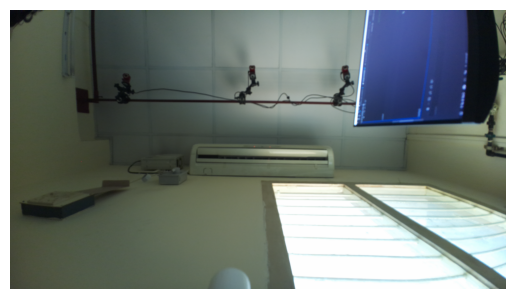

In [ ]:
desired_brightness = 0.5  # Set desired brightness level (0-1)
exposure_tolerance = 50  # Set tolerance for brightness adjustment

picam2.set_controls({'ExposureTime': 500000})

def set_exposure_time(exposure_time):
    """Set the exposure time for the camera"""
    desired_exposure_time = exposure_time  # Set desired exposure time in microseconds
    exposure_tolerance = 50  # Set tolerance for exposure adjustment
    
    picam2.set_controls({'ExposureTime': exposure_time})

    for i in range(5):
        actual_exposure = picam2.capture_metadata()['ExposureTime']
        print(actual_exposure)
        if abs(actual_exposure - desired_exposure_time) <= exposure_tolerance:
            break

while True:
    frame = picam2.capture_array()
    brightness = calculate_image_brightness(frame) / 255.0  # Normalize brightness to [0, 1]

    if abs(brightness - desired_brightness) <= exposure_tolerance:
        break

    # Adjust exposure time based on brightness
    if brightness < desired_brightness:
        set_exposure_time(picam2.get_controls()['ExposureTime'] + 20000)
    else:
        set_exposure_time(picam2.get_controls()['ExposureTime'] - 20000)



plt.imshow(frame)
plt.axis('off')



In [15]:
calculate_image_quality(frame)

{'avg_brightness': 112.15479679395469,
 'std_dev': 63.134096590029664,
 'hist_std': 63.1340963994115,
 'contrast_ratio': 6.864864864864865}